# Assignment 3

In [493]:
%run ../resources/resources.ipynb

In [494]:
# load geometry csv files
x_main, y_main = np.loadtxt(open('MainFoil_N=50.csv','r'), delimiter=',', dtype=float, unpack=True)
x_flap, y_flap = np.loadtxt(open('FlapFoil_N=50.csv','r'), delimiter=',', dtype=float, unpack=True)

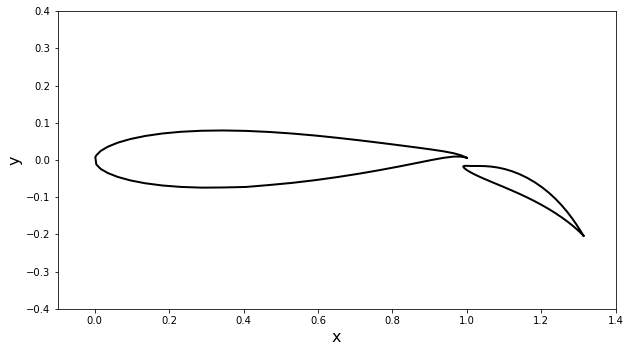

In [495]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.4, 0.4);

In [496]:
# discretization
N = 50
main_panels = define_panels(x_main, y_main, N)
flap_panels = define_panels(x_flap/np.cos(30*np.pi/180), y_flap/np.sin(30*np.pi/180), N=50)
for panel in flap_panels:
    panel.xa *= np.cos(30*np.pi/180)
    panel.ya *= np.sin(30*np.pi/180)
    panel.xc, panel.yc = (panel.xa+panel.xb)/2.0, (panel.ya+panel.yb)/2.0 
    panel.beta += 30*np.pi/180
    
panels = np.append(main_panels, flap_panels)

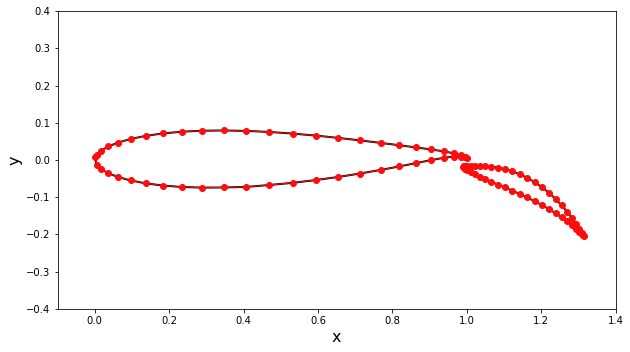

In [497]:
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xa for panel in panels[0:len(main_panels)]], [panel.ya for panel in panels[0:len(main_panels)]], color='#FF0D0D', linewidth=1, marker='o', markersize=6)
plt.plot([panel.xa for panel in panels[len(main_panels):]], [panel.ya for panel in panels[len(main_panels):]], color='#FF0D0D', linewidth=1, marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.4, 0.4);

In [498]:
# define free stream conditions
fs = Freestream(u_inf=1.0, alpha=0.0)

In [499]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [500]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [501]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 -np.sin(panel_i.beta),
                                                 np.cos(panel_i.beta))
    return A

In [502]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [503]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty([2, A_source.shape[0]+2], dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0, :-2] = B_vortex[0, :] + B_vortex[A_source.shape[0]/2-1, :]
    b[1, :-2] = B_vortex[A_source.shape[0]/2, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[:,-2] = - np.sum(A_source[0, :] + A_source[A_source.shape[0]/2-1, :])
    b[:,-1] = -np.sum(A_source[A_source.shape[0]/2, :] + A_source[-1, :])
    return b

In [504]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:, :B_vortex.shape[0]/2], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:, B_vortex.shape[0]/2+1:], axis=1)
    # Kutta condition array
    b = kutta_condition(A_source, B_vortex)
    A[-2, :] = b[0, :]
    A[-1, :] = b[1, :]
    return A

In [505]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                               +np.sin(freestream.alpha-panels[len(panels)/2-1].beta) )
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels[len(panels)/2].beta)
                               +np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [506]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, fs)

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__

In [507]:
strengths = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma_main = strengths[-2]
gamma_flap = strengths[-1]
gamma = np.append(gamma_main, gamma_flap)

In [508]:
gamma

array([-0.02960422,  0.14339018])

In [509]:
panels[51].beta

0.86585986662370606

In [510]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same as
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:, :len(panels)/2], axis=1)
    A[:, -1] = -np.sum(A_source[:, (len(panels)/2)+1:], axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [511]:
compute_tangential_velocity(panels, fs, gamma, A_source, B_vortex)

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [512]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [513]:
compute_pressure_coefficient(panels, fs)
x_main_theory, cp_main_theory = np.loadtxt(open('Cp_Main_theoretical.csv', 'r'), delimiter=',', dtype=float, unpack=True)

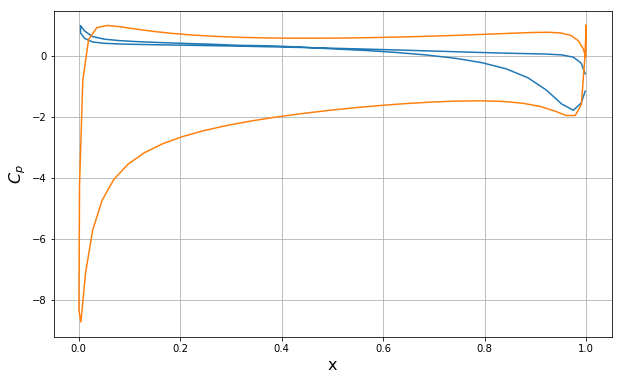

In [514]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels[:N]], [panel.cp for panel in panels[:N]])
plt.plot(x_main_theory, cp_main_theory);

In [515]:
panels[3].cp

0.034532924553637323

In [516]:
panels[59].cp

-0.62770122318384547

In [517]:
np.sum([panel.sigma for panel in panels])

12.526249241092643